## Download dataset from roboflow (yolov5 version of dataset)

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="KZo2u7XZFUW0de237okd")
project = rf.workspace("workspace-5ujvu").project("basketball-players-fy4c2-vfsuv")
version = project.version(17)
dataset = version.download("yolov5")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Basketball-Players-17 in yolov5pytorch:: 100%|██████████| 652/652 [00:00<00:00, 974.29it/s] 


(For syncing purposes, I put all data in a folder called `data` located in root.)

## EDA

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load class names from data.yaml
data_yaml_path = Path('../data/data.yaml')
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = data_config['nc']

print(f"Dataset: {num_classes} classes")
print(f"Classes: {class_names}")
print(f"\nClass ID mapping:")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name}")

Dataset: 7 classes
Classes: ['Ball', 'Clock', 'Hoop', 'Overlay', 'Player', 'Ref', 'Scoreboard']

Class ID mapping:
  0: Ball
  1: Clock
  2: Hoop
  3: Overlay
  4: Player
  5: Ref
  6: Scoreboard


#### Load and Parse All Label Files

In [2]:
def parse_yolo_labels(label_dir):
    """Parse all YOLO label files in a directory"""
    annotations = []
    label_path = Path(label_dir)
    
    for label_file in label_path.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    annotations.append({
                        'file': label_file.name,
                        'class_id': int(class_id),
                        'class_name': class_names[int(class_id)],
                        'x_center': x_center,
                        'y_center': y_center,
                        'width': width,
                        'height': height,
                        'area': width * height
                    })
    
    return pd.DataFrame(annotations)

# Parse labels from all splits
print("Parsing labels...")
train_df = parse_yolo_labels('../data/train/labels')
valid_df = parse_yolo_labels('../data/valid/labels')
test_df = parse_yolo_labels('../data/test/labels')

train_df['split'] = 'train'
valid_df['split'] = 'valid'
test_df['split'] = 'test'

# Combine all data
all_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

print(f"\nTotal annotations: {len(all_df):,}")
print(f"  Train: {len(train_df):,}")
print(f"  Valid: {len(valid_df):,}")
print(f"  Test: {len(test_df):,}")
print(f"\nUnique images: {all_df['file'].nunique():,}")

Parsing labels...

Total annotations: 4,640
  Train: 3,686
  Valid: 483
  Test: 471

Unique images: 320


#### Class Distribution Analysis

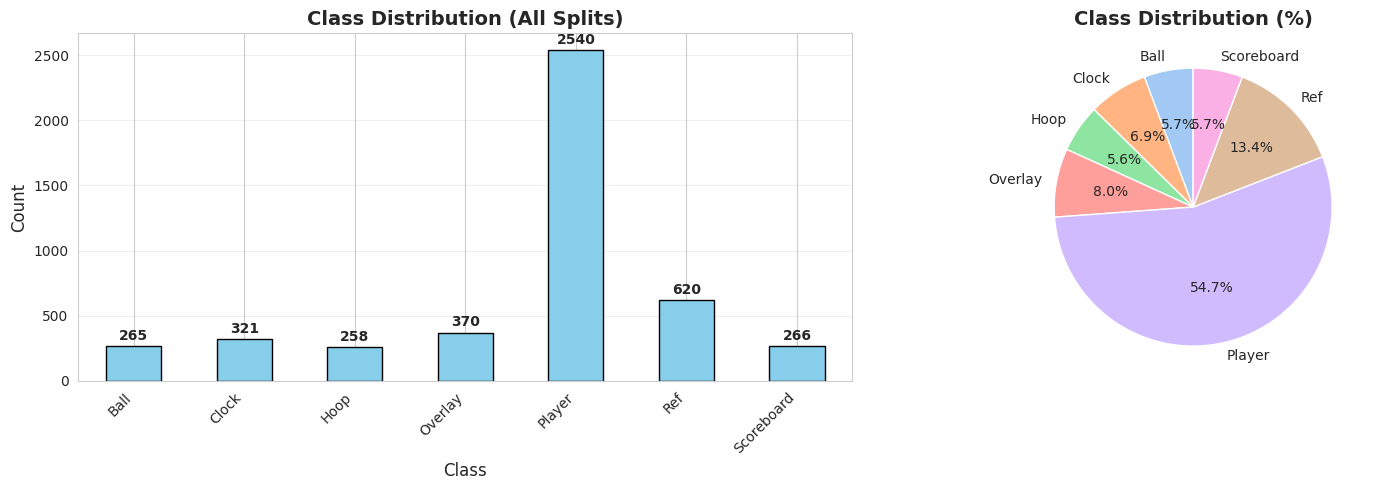


Class Distribution Summary:
            Count
class_name       
Ball          265
Clock         321
Hoop          258
Overlay       370
Player       2540
Ref           620
Scoreboard    266

Most common: Player (2,540 instances)
Least common: Hoop (258 instances)
Class imbalance ratio: 9.84:1


In [3]:
# Class distribution overall
class_counts = all_df['class_name'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
ax1 = axes[0]
class_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Class Distribution (All Splits)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add counts on bars
for i, v in enumerate(class_counts):
    ax1.text(i, v + max(class_counts)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

# Percentage breakdown
ax2 = axes[1]
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, 
                   colors=sns.color_palette('pastel'))
ax2.set_ylabel('')
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nClass Distribution Summary:")
print(class_counts.to_frame(name='Count'))
print(f"\nMost common: {class_counts.idxmax()} ({class_counts.max():,} instances)")
print(f"Least common: {class_counts.idxmin()} ({class_counts.min():,} instances)")
print(f"Class imbalance ratio: {class_counts.max() / class_counts.min():.2f}:1")

#### Bounding Box Size Analysis

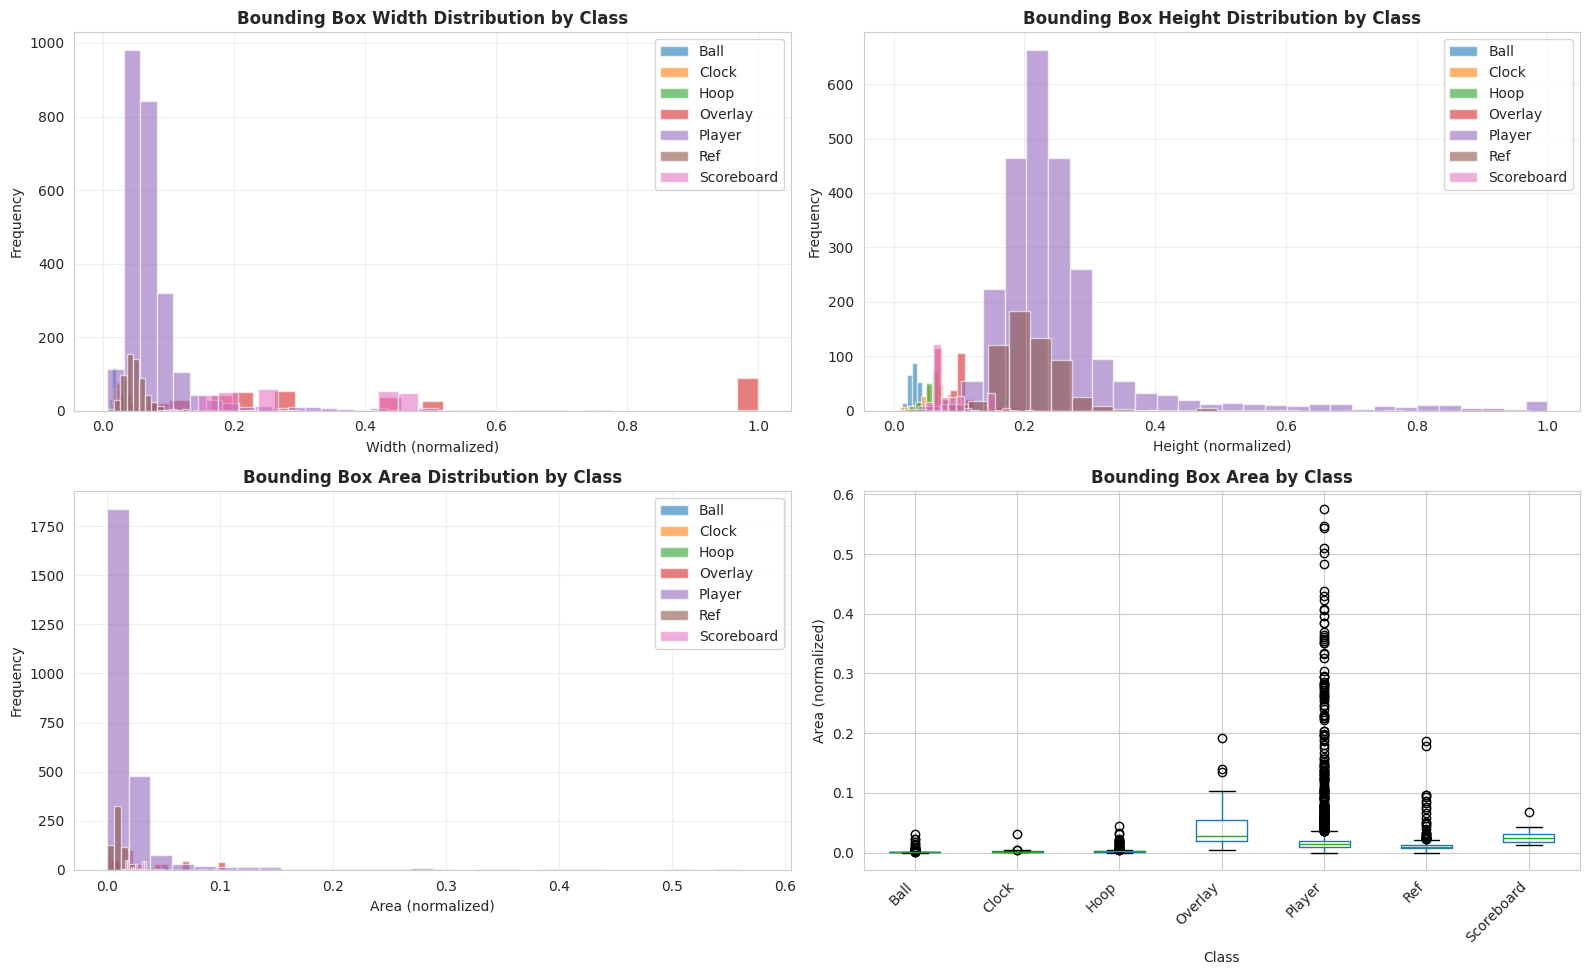


Bounding Box Statistics by Class:
             width                          height                          \
              mean     std     min     max    mean     std     min     max   
class_name                                                                   
Ball        0.0234  0.0190  0.0078  0.1836  0.0408  0.0289  0.0133  0.2391   
Clock       0.0283  0.0121  0.0055  0.1508  0.0610  0.0209  0.0094  0.2078   
Hoop        0.0398  0.0213  0.0102  0.1641  0.0731  0.0354  0.0062  0.2688   
Overlay     0.4405  0.3369  0.0359  1.0000  0.0984  0.0368  0.0508  0.4023   
Player      0.0750  0.0607  0.0062  0.7586  0.2596  0.1351  0.0039  1.0000   
Ref         0.0511  0.0264  0.0070  0.2898  0.2132  0.0717  0.0180  0.9719   
Scoreboard  0.3151  0.1351  0.0836  1.0000  0.0892  0.0376  0.0484  0.4016   

              area                          
              mean     std     min     max  
class_name                                  
Ball        0.0014  0.0033  0.0001  0.0308  
Cloc

In [4]:
# Bounding box size distribution by class
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Width distribution
ax1 = axes[0, 0]
for class_name in class_names:
    class_data = all_df[all_df['class_name'] == class_name]
    if len(class_data) > 0:
        ax1.hist(class_data['width'], alpha=0.6, label=class_name, bins=30)
ax1.set_title('Bounding Box Width Distribution by Class', fontsize=12, fontweight='bold')
ax1.set_xlabel('Width (normalized)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

# Height distribution
ax2 = axes[0, 1]
for class_name in class_names:
    class_data = all_df[all_df['class_name'] == class_name]
    if len(class_data) > 0:
        ax2.hist(class_data['height'], alpha=0.6, label=class_name, bins=30)
ax2.set_title('Bounding Box Height Distribution by Class', fontsize=12, fontweight='bold')
ax2.set_xlabel('Height (normalized)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

# Area distribution
ax3 = axes[1, 0]
for class_name in class_names:
    class_data = all_df[all_df['class_name'] == class_name]
    if len(class_data) > 0:
        ax3.hist(class_data['area'], alpha=0.6, label=class_name, bins=30)
ax3.set_title('Bounding Box Area Distribution by Class', fontsize=12, fontweight='bold')
ax3.set_xlabel('Area (normalized)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(alpha=0.3)

# Box plot of areas by class
ax4 = axes[1, 1]
all_df.boxplot(column='area', by='class_name', ax=ax4)
ax4.set_title('Bounding Box Area by Class', fontsize=12, fontweight='bold')
ax4.set_xlabel('Class')
ax4.set_ylabel('Area (normalized)')
plt.suptitle('')  # Remove default title
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Statistics by class
print("\nBounding Box Statistics by Class:")
stats = all_df.groupby('class_name')[['width', 'height', 'area']].agg(['mean', 'std', 'min', 'max'])
print(stats.round(4))

#### Objects Per Image Analysis

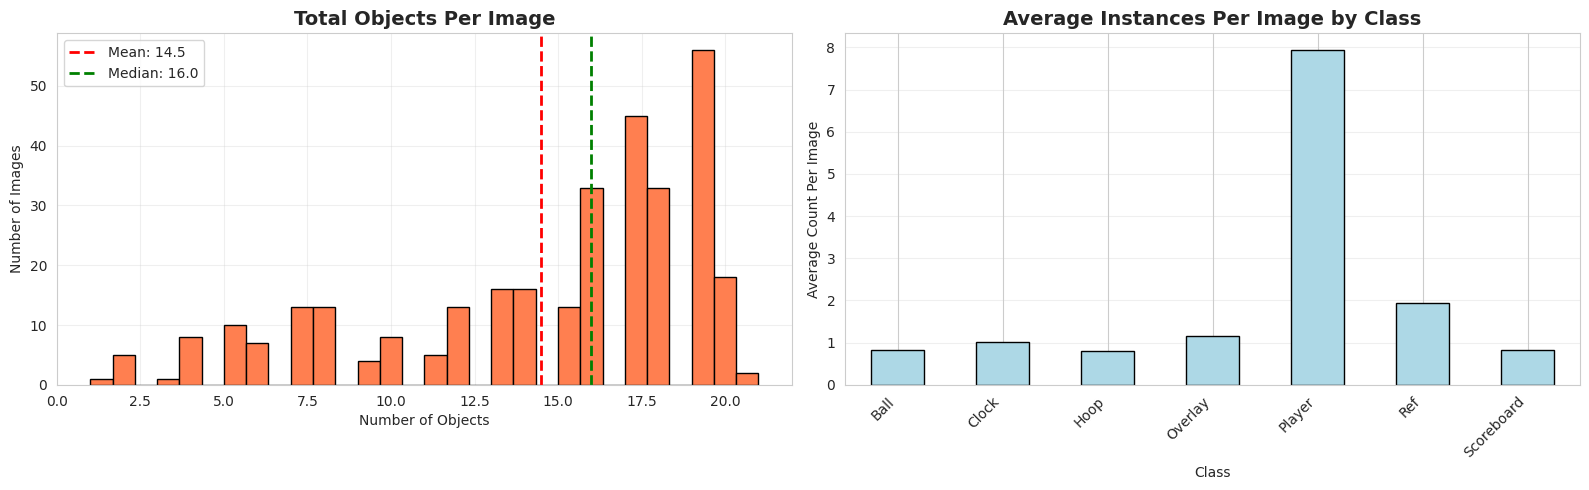


Objects Per Image Statistics:
Mean objects per image: 14.50
Median objects per image: 16.00
Max objects in single image: 21
Min objects in single image: 1

Average instances per image by class:
class_name
Player        7.94
Ref           1.94
Overlay       1.16
Clock         1.00
Scoreboard    0.83
Ball          0.83
Hoop          0.81
dtype: float64


In [5]:
# Count objects per image
objects_per_image = all_df.groupby(['file', 'class_name']).size().unstack(fill_value=0)
total_per_image = objects_per_image.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Total objects per image
ax1 = axes[0]
total_per_image.hist(bins=30, ax=ax1, color='coral', edgecolor='black')
ax1.set_title('Total Objects Per Image', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Objects')
ax1.set_ylabel('Number of Images')
ax1.axvline(total_per_image.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {total_per_image.mean():.1f}')
ax1.axvline(total_per_image.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {total_per_image.median():.1f}')
ax1.legend()
ax1.grid(alpha=0.3)

# Each class per image
ax2 = axes[1]
objects_per_image.mean().plot(kind='bar', ax=ax2, color='lightblue', edgecolor='black')
ax2.set_title('Average Instances Per Image by Class', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class')
ax2.set_ylabel('Average Count Per Image')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObjects Per Image Statistics:")
print(f"Mean objects per image: {total_per_image.mean():.2f}")
print(f"Median objects per image: {total_per_image.median():.2f}")
print(f"Max objects in single image: {total_per_image.max()}")
print(f"Min objects in single image: {total_per_image.min()}")

print("\nAverage instances per image by class:")
print(objects_per_image.mean().sort_values(ascending=False).round(2))

#### Player and Ball Specific Analysis

In [ ]:
# Analyze players per image
players_per_image = objects_per_image['Player'] if 'Player' in objects_per_image.columns else pd.Series(dtype=int)

# Analyze ball presence
images_with_ball = (objects_per_image['Ball'] > 0).sum() if 'Ball' in objects_per_image.columns else 0
total_images = len(objects_per_image)
ball_percentage = (images_with_ball / total_images * 100) if total_images > 0 else 0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram: Players per image
ax1 = axes[0]
if len(players_per_image) > 0:
    players_per_image.hist(bins=range(0, int(players_per_image.max()) + 2), 
                           ax=ax1, color='#4ECDC4', edgecolor='black', alpha=0.7)
    ax1.set_title('Players Per Image Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Players')
    ax1.set_ylabel('Number of Images')
    ax1.axvline(players_per_image.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {players_per_image.mean():.1f}')
    ax1.axvline(players_per_image.median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {players_per_image.median():.1f}')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_xlim(-0.5, players_per_image.max() + 0.5)

# Pie chart: Images with vs without ball
ax2 = axes[1]
ball_data = pd.Series({
    'With Ball': images_with_ball,
    'Without Ball': total_images - images_with_ball
})
colors = ['#FF6B6B', '#95E1D3']
ball_data.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_ylabel('')
ax2.set_title('Ball Presence in Images', fontsize=14, fontweight='bold')

# Bar chart: Ref presence
ax3 = axes[2]
key_objects = ['Player', 'Ball', 'Ref', 'Hoop']
presence_stats = []
for obj in key_objects:
    if obj in objects_per_image.columns:
        has_obj = (objects_per_image[obj] > 0).sum()
        pct = (has_obj / total_images * 100)
        presence_stats.append({'Object': obj, 'Percentage': pct})

if presence_stats:
    presence_df = pd.DataFrame(presence_stats)
    presence_df.plot(x='Object', y='Percentage', kind='bar', ax=ax3, 
                     color='#FFB6B9', edgecolor='black', legend=False)
    ax3.set_title('Object Presence in Images', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Object Type')
    ax3.set_ylabel('% of Images')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim(0, 100)
    
    # Add percentage labels on bars
    for i, v in enumerate(presence_df['Percentage']):
        ax3.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("PLAYER STATISTICS")
print("="*60)
if len(players_per_image) > 0:
    print(f"Average players per image: {players_per_image.mean():.2f}")
    print(f"Median players per image: {players_per_image.median():.0f}")
    print(f"Max players in single image: {players_per_image.max()}")
    print(f"Min players in single image: {players_per_image.min()}")
    print(f"Images with 0 players: {(players_per_image == 0).sum()} ({(players_per_image == 0).sum()/len(players_per_image)*100:.1f}%)")
    print(f"Most common player count: {players_per_image.mode().values[0]} players")

print("\n" + "="*60)
print("BALL STATISTICS")
print("="*60)
print(f"Images with ball: {images_with_ball} / {total_images} ({ball_percentage:.1f}%)")
print(f"Images without ball: {total_images - images_with_ball} / {total_images} ({100-ball_percentage:.1f}%)")

print("\n" + "="*60)
print("OBJECT PRESENCE SUMMARY")
print("="*60)
for obj_stat in presence_stats:
    print(f"{obj_stat['Object']:12s}: {obj_stat['Percentage']:5.1f}% of images")

#### Train/Valid/Test Split Analysis

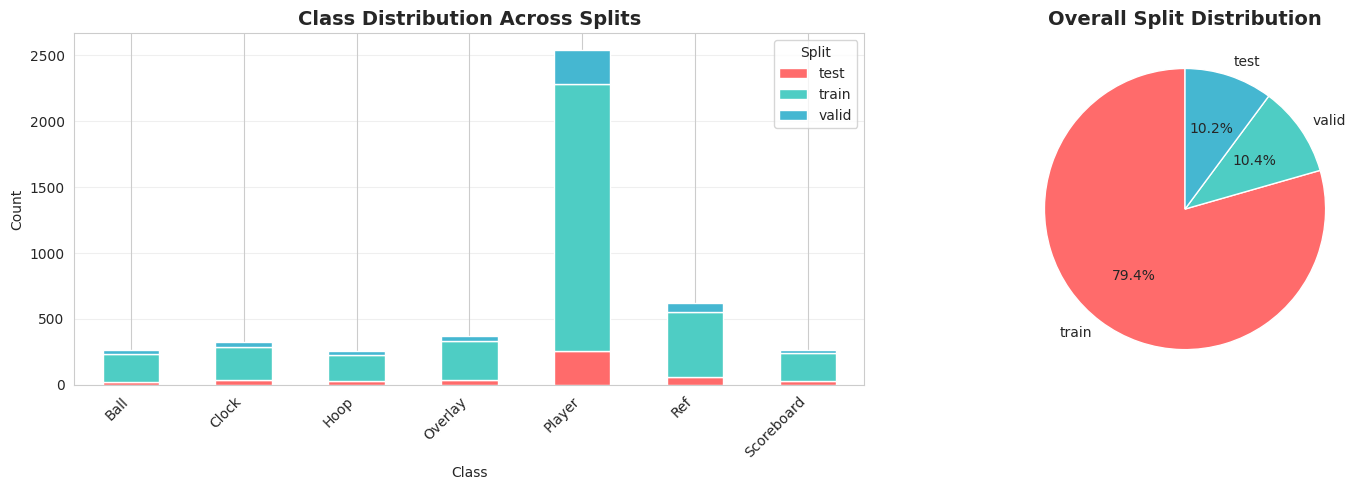


Split Distribution:
class_name  Ball  Clock  Hoop  Overlay  Player  Ref  Scoreboard
split                                                          
test          24     37    25       36     260   61          28
train        213    249   203      294    2021  495         211
valid         28     35    30       40     259   64          27

Total images per split:
  Train: 256 images, 3,686 annotations
  Valid: 32 images, 483 annotations
  Test: 32 images, 471 annotations


In [6]:
# Analyze split distribution
split_stats = all_df.groupby(['split', 'class_name']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Stacked bar chart
ax1 = axes[0]
split_stats.T.plot(kind='bar', stacked=True, ax=ax1, 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(title='Split')
ax1.grid(axis='y', alpha=0.3)

# Split percentages
ax2 = axes[1]
split_totals = all_df['split'].value_counts()
split_totals.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90,
                   colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_ylabel('')
ax2.set_title('Overall Split Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSplit Distribution:")
print(split_stats)
print(f"\nTotal images per split:")
for split in ['train', 'valid', 'test']:
    split_data = all_df[all_df['split'] == split]
    n_images = split_data['file'].nunique()
    n_annotations = len(split_data)
    print(f"  {split.capitalize()}: {n_images:,} images, {n_annotations:,} annotations")

#### Class Co-occurrence Analysis

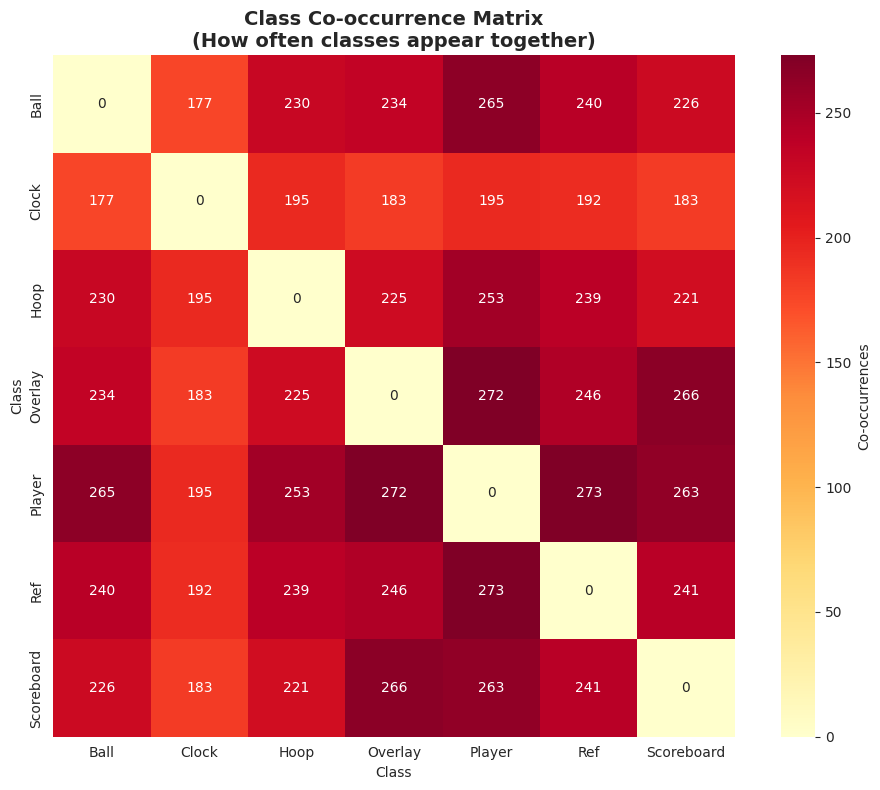


Most Common Class Pairs:
  Player + Ref: 273 images
  Overlay + Player: 272 images
  Overlay + Scoreboard: 266 images
  Ball + Player: 265 images
  Player + Scoreboard: 263 images
  Hoop + Player: 253 images
  Overlay + Ref: 246 images
  Ref + Scoreboard: 241 images
  Ball + Ref: 240 images
  Hoop + Ref: 239 images


In [7]:
# Create co-occurrence matrix
from itertools import combinations

# Get which classes appear in each image
class_per_image = all_df.groupby('file')['class_name'].apply(set)

# Build co-occurrence matrix
cooccurrence = pd.DataFrame(0, index=class_names, columns=class_names)

for classes_in_image in class_per_image:
    for class1, class2 in combinations(classes_in_image, 2):
        cooccurrence.loc[class1, class2] += 1
        cooccurrence.loc[class2, class1] += 1

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='YlOrRd', 
            square=True, cbar_kws={'label': 'Co-occurrences'})
plt.title('Class Co-occurrence Matrix\n(How often classes appear together)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

print("\nMost Common Class Pairs:")
# Get upper triangle values
pairs = []
for i in range(len(class_names)):
    for j in range(i+1, len(class_names)):
        pairs.append((class_names[i], class_names[j], cooccurrence.iloc[i, j]))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
for class1, class2, count in pairs_sorted[:10]:
    print(f"  {class1} + {class2}: {int(count):,} images")

### Train Yolo

In [ ]:
!yolo task=detect mode=train model=yolov5l6u.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True batch=-1